In [1]:
from bip_functions import FL, FL_broadcast, logpriorL, sample_priorL
from bip_functions import log_epanechnikov_kernelL, log_posteriorL, grad_FL, hess_FL

from tangential_hug_functions import Hug, HugTangential

from scipy.stats import multivariate_normal as MVN
from numpy import zeros, eye, sqrt
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm

#### Hug

In [2]:
# Settings
T = 1.0
B = 5
N = 8000
q = MVN(zeros(3), eye(3))
y = 1.0
σ = 0.001
ϵ = 0.01

# Deterministic function, gradient and hessian
f      = lambda ξ: ξ[1]**2 + 3*(ξ[0]**2)*(ξ[0]**2 - 1) + σ*ξ[2]
grad_f = lambda ξ: np.array([12*(ξ[0]**3) - 6*ξ[0], 2*ξ[1], σ])
hess_f = lambda ξ: np.array([[36*(ξ[0]**2) - 6, 0, 0], [0, 2, 0], [0, 0, 0]])

# Posterior distribution 
logpi = lambda x: log_posteriorL(x, ϵ, σ, y)

In [3]:
# need to find point near manifold, right now do it in a crude way
def find_starting_point(n_attempts=1000):
    x_start = None
    for i in range(1000):
        x0 = sample_priorL()
        if log_posteriorL(x0, ϵ, σ, y) > -np.inf:
            x_start = x0
            break
    if x_start is None:
        print("None found.")
    return x_start
x0 = find_starting_point()

In [4]:
# Need to find point 
samples, acceptances = Hug(x0, T, B, N, q, logpi, grad_f)

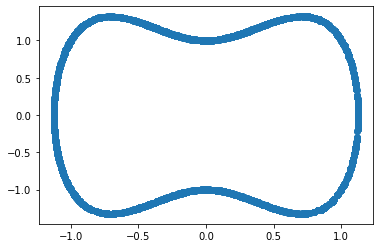

In [5]:
plt.scatter(*samples[:, :2].T)
plt.show()

### GPV

In [6]:
from numpy.random import rand
from autograd.numpy.linalg import norm
import autograd.numpy as anp
from autograd import jacobian, hessian
from scipy.optimize import fsolve

In [7]:
def integratorγ2(ξ):
    """This integrator always chooses γ1."""
    n = len(ξ) // 2
    x0, v0 = ξ[:n], ξ[n:]
    x1 = x0 + (δ/2)*v0
    g1 = grad_f(x1); gnorm1 = norm(g1); g1hat = g1 / gnorm1
    H1 = hess_f(x1)
    b = -(δ/2)* g1hat / gnorm1
    a = v0 + b * (v0 @ (H1 @ v0))
    c1 = b @ (H1 @ b)
    c2 = 2 * a @ (H1 @ b) - 1
    c3 = a @ (H1 @ a)
    Δ = c2**2 - 4*c1*c3
    print("Δ: ", Δ)
    if Δ >= 0:
        γ = (-c2 - sqrt(Δ)) / (2*c1)
        v1 = a + b*γ
        x2 = x1 + (δ/2) * v1
        return np.concatenate((x2, v1))
    else:
        print("Discriminat is negative.")
        return np.concatenate((x0, -v0))

### Reversibility

In [8]:
def check_reversibility(integrator, ξ, δ):
    out  = integrator(ξ)
    out1 = np.concatenate((out[:3], -out[3:]))
    out2 = integrator(out1)
    out3 = np.concatenate((out2[:3], -out2[3:]))
    return ξ - out3

In [9]:
# Random starting point
x0 = find_starting_point()
v0 = q.rvs()
ξ = np.concatenate((x0, v0))
δ = T / B

In [10]:
check_reversibility(integratorγ2, ξ, δ)

Δ:  1.5498657129088418
Δ:  0.43381387568802054


array([-1.11022302e-16,  0.00000000e+00,  0.00000000e+00,  1.11022302e-16,
        2.22044605e-16,  0.00000000e+00])

In [11]:
import autograd.numpy as anp
from autograd import jacobian

In [12]:
# Re-define functions
grad_f_anp = lambda ξ: anp.array([12*(ξ[0]**3) - 6*ξ[0], 2*ξ[1], σ])
hess_f_anp = lambda ξ: anp.array([[36*(ξ[0]**2) - 6, 0, 0], [0, 2, 0], [0, 0, 0]])

In [432]:
def integratorγ2_function(ξ):
    """This integrator always chooses γ1."""
    n = len(ξ) // 2
    x0, v0 = ξ[:n], ξ[n:]
    x1 = x0 + (δ/2)*v0
    g1 = grad_f_anp(x1); gnorm1 = anp.linalg.norm(g1); g1hat = g1 / gnorm1
    H1 = hess_f_anp(x1)
    b = -(δ/2)* g1hat / gnorm1
    a = v0 + b * (v0 @ (H1 @ v0))
    c1 = b @ (H1 @ b)
    c2 = 2 * a @ (H1 @ b) - 1
    c3 = a @ (H1 @ a)
    Δ = c2**2 - 4*c1*c3
    if Δ >= 0:
        γ = (-c2 - anp.sqrt(Δ)) / (2*c1)
        v1 = a + b*γ
        x2 = x1 + (δ/2) * v1
        return anp.concatenate((x2, v1))
    else:
        print('rejected')
        anp.concatenate((x0, -v0))

In [493]:
def integratorγ2_function_allinone(ξ):
    """Basically we remove all if statements."""
    n = len(ξ) // 2
    x0, v0 = ξ[:n], ξ[n:]
    x1 = x0 + (δ/2)*v0
    g1 = grad_f_anp(x1); gnorm1 = anp.linalg.norm(g1); g1hat = g1 / gnorm1
    H1 = hess_f_anp(x1)
    b = -(δ/2)* g1hat / gnorm1
    a = v0 + b * (v0 @ (H1 @ v0))
    c1 = b @ (H1 @ b)
    c2 = 2 * a @ (H1 @ b) - 1
    c3 = a @ (H1 @ a)
    Δ = c2**2 - 4*c1*c3
    flag = anp.sign(anp.sign(Δ) + 1)           # flag = 0 when Δ < 0, otherwise flag=1
    γ = (-c2 - anp.sqrt(abs(Δ))) / (2*c1)
    v1 = flag * (a + b*γ) + (1 - flag) * (-v0)
    x2 = x1 + (δ/2) * v1
    return anp.concatenate((x2, v1))

In [617]:
### velocity version!!
def gvv_integrator(ξ):
    n = len(ξ) // 2
    x0, v0 = ξ[:n], ξ[n:]
    g0 = grad_f_anp(x0); gnorm0 = anp.linalg.norm(g0); g0hat = g0 / gnorm0
    H0 = hess_f_anp(x0)
    a = -(δ / 2)*g0hat/gnorm0  # v_{n+1/2} = v_n + aγ
    c1 = a @ (H0 @ a)
    c2 = 2*(a @ (H0 @ v0)) - 1
    c3 = v0 @ (H0 @ v0)
    Δ1 = c2**2 - 4*c1*c3
    print('Δ1: ', Δ1)
    if Δ1 >= 0:
        γ1 = (-c2 - anp.sqrt(Δ1)) / (2*c1)
        vhalf = v0 + a*γ1
        x1 = x0 + δ*vhalf
        g1 = grad_f_anp(x1); gnorm1 = anp.linalg.norm(g1); g1hat = g1 / gnorm1
        H1 = hess_f_anp(x1)
        b = -(δ / 2)*g1hat/gnorm1
        d1 = b @ (H1 @ b)
        d2 = 2*(b @ (H1 @ vhalf)) - 1
        d3 = vhalf @ (H1 @ vhalf)
        Δ2 = d2**2 - 4*d1*d3
        print('Δ2: ', Δ2)
        if Δ2 >= 0:
            γ2 = (-d2 - anp.sqrt(Δ2)) / (2*d1)
            v1 = vhalf + b*γ2
            return anp.concatenate((x1, v1))
        else:
            return anp.concatenate((x0, -v0))
    else:
        return anp.concatenate((x0, -v0))

In [631]:
check_reversibility(gvv_integrator, ξ, δ)

Δ1:  0.6655128721085591
Δ2:  0.676158748108428
Δ1:  1.4062182410965665
Δ2:  1.3905097123694599


array([ 5.19351515e-03, -5.93606083e-03, -3.81736061e-06, -3.82637369e-02,
        4.76775001e-02,  2.78039799e-05])

In [632]:
np.linalg.det(jacobian(gvv_integrator)(ξ))

Δ1:  Autograd ArrayBox with value 0.6655128721085591
Δ2:  Autograd ArrayBox with value 0.676158748108428


1.490724655459687

In [630]:
# Random starting point
x0 = find_starting_point()
v0 = q.rvs()
ξ = np.concatenate((x0, v0))
δ = T / B

### Symplecticness

In [433]:
def perpendicularize(v, x):
    g = grad_f(x); ghat = g / norm(g)
    vperp = v - (ghat @ v) * ghat
    return vperp * norm(v) / norm(vperp)

In [434]:
Γ = np.array([[0, 0, 0, -1, 0, 0],
              [0, 0, 0, 0, -1, 0],
              [0, 0, 0, 0, 0, -1],
              [1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])
Γinv = np.linalg.inv(Γ)

In [494]:
# Point at which Jacobian will be computed. This is perpendicularized meaning
# that the velocity is made perpendicular to the gradient at x0
ξ_perp = np.concatenate((x0, perpendicularize(v0, x0)))

# Jacobian at perpendicularized initial point
J_perp               = jacobian(integratorγ2_function)(ξ_perp)
det_Jperp            = np.linalg.det(J_perp)
JperpΓinvJperp       = J_perp.T @ (Γinv @ J_perp)
def_JperpΓinvJperp   = np.linalg.det(JperpΓinvJperp)
print("det(Jperp):          ", det_Jperp)
print("det(JperpΓinvJperp): ", def_JperpΓinvJperp)

det(Jperp):           1.3276657321663765
det(JperpΓinvJperp):  1.76269629636888


In [495]:
# Point at which Jacobian will be computed. This is NOT perpendicularized 
ξ = np.concatenate((x0, v0))

# Jacobian at perpendicularized initial point
J                = jacobian(integratorγ2_function)(ξ)
det_J            = np.linalg.det(J)
JΓinvJ           = J.T @ (Γinv @ J)
def_JΓinvJ       = np.linalg.det(JΓinvJ)
print("det(J):      ", det_J)
print("det(JΓinvJ): ", def_JΓinvJ)

det(J):       0.9911534888256949
det(JΓinvJ):  0.9823852384113472


In [496]:
JΓinvJ.round()

array([[ 0., -1.,  0.,  1., -0.,  0.],
       [ 1.,  0.,  0.,  1.,  1.,  0.],
       [-0., -0.,  0., -0.,  0.,  1.],
       [-1., -1.,  0.,  0., -0.,  0.],
       [ 0., -1., -0.,  0.,  0., -0.],
       [-0., -0., -1., -0.,  0.,  0.]])

In [497]:
JperpΓinvJperp.round()

array([[-0., -3.,  0.,  1., -0.,  0.],
       [ 3.,  0.,  0.,  1.,  1.,  0.],
       [-0., -0.,  0., -0.,  0.,  1.],
       [-1., -1.,  0., -0., -0.,  0.],
       [ 0., -1., -0.,  0., -0., -0.],
       [-0., -0., -1., -0.,  0.,  0.]])

In [58]:
from scipy.optimize import fsolve

In [296]:
def find_x_on_manifold(x_start=None):
    x_start = MVN(zeros(3), eye(3)).rvs()
    return fsolve(lambda x: [f(x) - y, 0, 0], x_start)

In [428]:
x_manifold = find_x_on_manifold()
v0 = q.rvs()
ξ_manifold = np.concatenate((x_manifold, perpendicularize(v0, x_manifold)))

In [429]:
Jm = jacobian(integratorγ2_function)(ξ_manifold)

In [430]:
np.linalg.det(Jm)

0.6132259772791236

In [431]:
(Jm.T @ (Γinv @ Jm)).round(1)

array([[-0. , -9.3,  0. ,  0.6, -0.9,  0. ],
       [ 9.3,  0. ,  0. , -0.1,  1. ,  0. ],
       [-0. , -0. ,  0. ,  0. , -0. ,  1. ],
       [-0.6,  0.1, -0. , -0. ,  0. , -0. ],
       [ 0.9, -1. ,  0. , -0. ,  0. ,  0. ],
       [-0. , -0. , -1. ,  0. , -0. ,  0. ]])

In [380]:
Γinv

array([[ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.],
       [-1., -0., -0., -0., -0., -0.],
       [-0., -1., -0., -0., -0., -0.],
       [-0., -0., -1., -0., -0., -0.]])

In [303]:
np.linalg.det(Jm.T @ (Γinv @ Jm))

0.668919962671927

In [304]:
np.linalg.det(Jm)

0.8178752732977854

In [305]:
np.linalg.det(Γinv)

1.0

### Check order

In [283]:
def integratorγ2_withδ(ξ, δ):
    """This integrator always chooses γ1."""
    n = len(ξ) // 2
    x0, v0 = ξ[:n], ξ[n:]
    x1 = x0 + (δ/2)*v0
    g1 = grad_f(x1); gnorm1 = norm(g1); g1hat = g1 / gnorm1
    H1 = hess_f(x1)
    b = -(δ/2)* g1hat / gnorm1
    a = v0 + b * (v0 @ (H1 @ v0))
    c1 = b @ (H1 @ b)
    c2 = 2 * a @ (H1 @ b) - 1
    c3 = a @ (H1 @ a)
    Δ = c2**2 - 4*c1*c3
    if Δ >= 0:
        γ = (-c2 - sqrt(Δ)) / (2*c1)
        v1 = a + b*γ
        x2 = x1 + (δ/2) * v1
        return np.concatenate((x2, v1))
    else:
        raise ValueError("Negative Discriminant.")



def check_order(x0, N, δ, perpendicular=False, thug=False, α=None):
    """Checks if true hug is second order."""
    average_difference = 0.0
    i = 0
    while i <= N:
        v0 = q.rvs()
        if perpendicular:
            v0norm = norm(v0)
            g0 = grad_f(x0); g0hat = g0 / norm(g0)
            v0 = v0 - (v0 @ g0hat) * g0hat
            v0 = v0 * v0norm / norm(v0)
        elif not perpendicular and thug and α is not None:
            g0 = grad_f(x0); g0hat = g0 / norm(g0)
            v0 = v0 - α * (v0 @ g0hat) * g0hat
        ξ0 = np.concatenate((x0, v0))
        try:
            ξ1 = integratorγ2_withδ(ξ0, δ)
        except ValueError:
            continue
        else:
            average_difference += abs(f(ξ1[:3]) - f(ξ0[:3])) 
            i += 1
    return average_difference / i

In [284]:
check_order(x0, 1000, 0.1, perpendicular=True)

0.0038429705377409262